## Neural tangent kernel

https://www.inference.vc/neural-tangent-kernels-some-intuition-for-kernel-gradient-descent/

In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

from jax import jacrev, jit, vmap

%matplotlib inline

In [2]:
def f(theta, x):
    return theta[0] * x + theta[1]


def f_map(thetas, x):
    return vmap(lambda theta: f(theta, x))(thetas)



def l(theta, x, y):
    return jnp.square(y - f(theta, x))


def l_grad(theta, x, y):
    return jacrev(l)(theta, x, y)


@jit
def ntk(x_train, y_train, x_test, theta, eta):
    # gradient step per training example
    theta_step = eta * l_grad(theta, x_train, y_train)
    theta_new = theta - theta_step
    
    # overall gradient step
    theta_step_mean = jnp.mean(theta_step, axis=0)
    
    # kernel matrix (#train, #test) 
    k = (f_map(theta_new, x_test) - f(theta, x_test)) / eta

    return k, theta - theta_step_mean

In [3]:
theta_0 = jnp.array([0.0, 0.0])

x_train = jnp.array([-3.0, 5.0, 10.0])
y_train = jnp.array([-12.0, 20.0, 50.0])

x_test = jnp.arange(-10.0, 20.0)

In [4]:
kernel, _ = ntk(x_train, y_train, x_test, theta_0, eta=0.01)

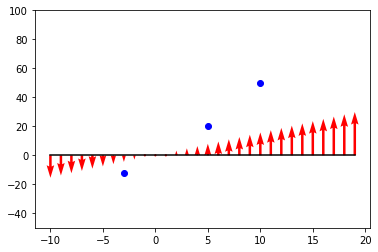

In [5]:
plt.plot(x_test, f(theta_0, x_test), c='k')
plt.quiver(x_test, f(theta_0, x_test), jnp.zeros_like(x_test), jnp.sum(kernel, axis=0), color='r')
plt.scatter(x_train, y_train, c='b')
plt.ylim(-50, 100);

In [6]:
theta = theta_0

for i in range(1000):
    kernel, theta = ntk(x_train, y_train, x_test, theta, eta=0.01)

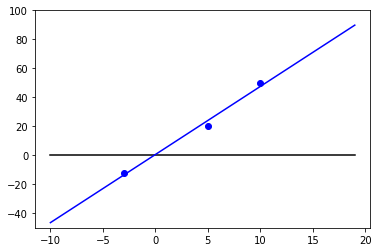

In [7]:
plt.plot(x_test, f(theta_0, x_test), c='k')
plt.plot(x_test, f(theta, x_test), c='b')
plt.scatter(x_train, y_train, c='b')
plt.ylim(-50, 100);

In [8]:
jnp.sum(kernel, axis=0)

DeviceArray([-3.9672852e-04,  0.0000000e+00,  3.9672852e-04,
              7.6293945e-04, -1.8310547e-04, -5.4931641e-04,
             -1.8310547e-04,  0.0000000e+00,  0.0000000e+00,
              2.2888184e-05,  5.2452087e-06,  0.0000000e+00,
              0.0000000e+00,  0.0000000e+00, -1.8310547e-04,
              2.1362305e-04, -1.8310547e-04,  0.0000000e+00,
              3.9672852e-04,  7.6293945e-04,  1.1291504e-03,
              0.0000000e+00,  4.2724609e-04,  8.5449219e-04,
             -7.3242188e-04,  7.3242188e-04,  0.0000000e+00,
             -7.3242188e-04,  8.5449219e-04,  6.1035156e-05],            dtype=float32)